In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel(r'G:\traindata\RFMtest\tmp.xlsx')
df.head()

,payment,trdtime,id,name
0,1.0,2019-12-25 01:07:14,13,吕游
1,NaN,2019-12-30 07:39:22,13,吕游
2,48.5,2020-06-22 11:51:51,46,卢芬
3,16.5,2020-06-27 02:32:09,46,卢芬
4,221.4,2020-06-30 12:15:34,46,卢芬


In [4]:
df['trdtime'] = pd.to_datetime(df['trdtime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   payment  390 non-null    float64       
 1   trdtime  394 non-null    datetime64[ns]
 2   id       394 non-null    int64         
 3   name     393 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 12.4+ KB


In [5]:
df['trdtime'].min()

Timestamp('2019-12-25 01:07:14')

In [6]:
R_today = dt.datetime(2020,8,27)

In [7]:
df['R_diff'] = (R_today-df['trdtime']).dt.days
df.head()

,payment,trdtime,id,name,R_diff
0,1.0,2019-12-25 01:07:14,13,吕游,245
1,NaN,2019-12-30 07:39:22,13,吕游,240
2,48.5,2020-06-22 11:51:51,46,卢芬,65
3,16.5,2020-06-27 02:32:09,46,卢芬,60
4,221.4,2020-06-30 12:15:34,46,卢芬,57


In [8]:
R = df.groupby(by = ['id'])['R_diff']
R.head()

0      245
1      240
2       65
3       60
4       57
      ... 
389      2
390      2
391      2
392      2
393      1
Name: R_diff, Length: 373, dtype: int64

In [9]:
R = R.agg([('R_diff','min')])
R.head()

,R_diff
id,
13,240
46,38
48,13
51,18
82,239


In [10]:
F = df.groupby(by = ['id'])['id'].agg([('F_fre','count')])

In [11]:
M = df.groupby(by = ['id'])['payment'].agg([('M_sum',sum)])
RFM = R.join(F).join(M)
RFM.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262 entries, 13 to 514
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   R_diff  262 non-null    int64  
 1   F_fre   262 non-null    int64  
 2   M_sum   262 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 18.2 KB


In [12]:
person = RFM.groupby(by = ['F_fre'])['F_fre'].agg([('F_fre','count')])
person.head(20)

,F_fre
F_fre,
1,198
2,40
3,11
4,3
5,2
6,3
7,3
8,1
14,1


In [13]:
RFM.describe()

,R_diff,F_fre,M_sum
count,262.000000,262.000000,262.000000
mean,29.015267,1.503817,72.784733
std,24.710891,1.352585,97.306767
min,1.000000,1.000000,1.000000
25%,18.000000,1.000000,24.350000
50%,26.000000,1.000000,42.950000
75%,34.000000,1.000000,79.400000
max,240.000000,14.000000,964.700000


In [14]:
RFM["R_score"]=np.where(RFM.R_diff<=18,4,np.where(RFM.R_diff<=26,3,np.where(RFM.R_diff<=34,2,1)))
RFM["F_score"]=np.where(RFM.F_fre<=1,1,np.where(RFM.F_fre<=2,2,np.where(RFM.F_fre<=3,3,4)))
RFM["M_score"]=np.where(RFM.M_sum<=24.35,1,np.where(RFM.M_sum<=42.95,2,np.where(RFM.M_sum<=79.4,3,4)))
RFM.head()

,R_diff,F_fre,M_sum,R_score,F_score,M_score
id,,,,,,
13,240,2,1.0,1,2,1
46,38,5,347.4,1,4,4
48,13,4,170.6,4,4,4
51,18,7,606.3,4,4,4
82,239,4,1.0,1,4,1


In [15]:
# RFM['RFM'] = 0.2*R1.astype(int)+0.3*F1.astype(int)+0.5*M1.astype(int)
# RFM.head()

In [16]:
RFM["RFM"] = RFM["R_score"]*0.4+RFM["F_score"]*0.1+RFM["M_score"]*0.5
RFM.head()

,R_diff,F_fre,M_sum,R_score,F_score,M_score,RFM
id,,,,,,,
13,240,2,1.0,1,2,1,1.1
46,38,5,347.4,1,4,4,2.8
48,13,4,170.6,4,4,4,4.0
51,18,7,606.3,4,4,4,4.0
82,239,4,1.0,1,4,1,1.3


In [17]:
bins = RFM.RFM.quantile(q = np.linspace(0,1,num = 9),interpolation = 'nearest')
labels = ['潜在客户','一般发展客户','一般保持客户','一般价值客户','重要挽留客户','重要发展客户','重要保持客户','高价值客户']
RFM['types'] = pd.cut(RFM.RFM,bins = bins,labels = labels,include_lowest = True)
RFM.head()

,R_diff,F_fre,M_sum,R_score,F_score,M_score,RFM,types
id,,,,,,,,
13,240,2,1.0,1,2,1,1.1,潜在客户
46,38,5,347.4,1,4,4,2.8,重要发展客户
48,13,4,170.6,4,4,4,4.0,高价值客户
51,18,7,606.3,4,4,4,4.0,高价值客户
82,239,4,1.0,1,4,1,1.3,潜在客户


In [18]:
df1 = RFM.reset_index()
df1
# df1.to_excel("testYD11.xlsx")

In [19]:
Money = df1.groupby(by = ['types'])['M_sum'].agg([('money_diff',sum)]).reset_index()
Money.head(9)

,types,money_diff
0,潜在客户,492.8
1,一般发展客户,784.3
2,一般保持客户,1659.9
3,一般价值客户,1056.2
4,重要挽留客户,2680.4
5,重要发展客户,2582.6
6,重要保持客户,3259.5
7,高价值客户,6553.9


In [20]:
Person = df1.groupby(by = ['types'])['types'].agg([('num','count')]).reset_index()
Person.head(9)

,types,num
0,潜在客户,36
1,一般发展客户,33
2,一般保持客户,39
3,一般价值客户,32
4,重要挽留客户,27
5,重要发展客户,30
6,重要保持客户,36
7,高价值客户,29


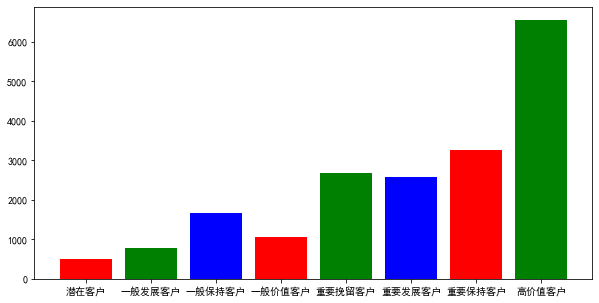

In [21]:
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False   #如果表中有中文，则需要添加上面两行
plt.figure(figsize=(10,5))
plt.bar(data=Money,x = 'types',height = 'money_diff',color = 'rgb')
plt.show()

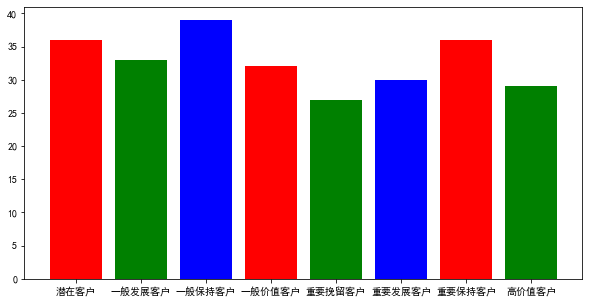

In [22]:
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False   #如果表中有中文，则需要添加上面两行
plt.figure(figsize=(10,5))
plt.bar(data=Person,x = 'types',height = 'num',color = 'rgb')
plt.show()

In [26]:
RFM_TEST = RFM.copy()
RFM_TEST.describe()

,R_diff,F_fre,M_sum,R_score,F_score,M_score,RFM
count,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000
mean,29.015267,1.503817,72.784733,2.549618,1.385496,2.500000,2.408397
std,24.710891,1.352585,97.306767,1.129295,0.787996,1.123589,0.809999
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,18.000000,1.000000,24.350000,2.000000,1.000000,1.250000,1.800000
50%,26.000000,1.000000,42.950000,3.000000,1.000000,2.500000,2.400000
75%,34.000000,1.000000,79.400000,4.000000,1.000000,3.750000,3.000000
max,240.000000,14.000000,964.700000,4.000000,4.000000,4.000000,4.000000


In [25]:
cluster=[]
for i in range(len(RFM_TEST)):
    if RFM_TEST.iloc[i,3] >= 3 and RFM_TEST.iloc[i,4] >=2 and RFM_TEST.iloc[i,5] >=3:
        cluster.append('高价值客户')
    elif RFM_TEST.iloc[i,3] < 3 and RFM_TEST.iloc[i,4] >= 2 and RFM_TEST.iloc[i,5] >=3:
        cluster.append('重点保持客户')
    elif RFM_TEST.iloc[i,3] >= 3 and RFM_TEST.iloc[i,4] < 2 and RFM_TEST.iloc[i,5] >=3:
        cluster.append('重点发展客户')
    elif RFM_TEST.iloc[i,3] < 3 and RFM_TEST.iloc[i,4] < 2 and RFM_TEST.iloc[i,5] >= 3:
        cluster.append('重点挽留客户')
    elif RFM_TEST.iloc[i,3] >= 3 and RFM_TEST.iloc[i,4] >= 2 and RFM_TEST.iloc[i,5] < 3:
        cluster.append('一般价值客户')
    elif RFM_TEST.iloc[i,3] < 3 and RFM_TEST.iloc[i,4] >= 2 and RFM_TEST.iloc[i,5] < 3:
        cluster.append('一般保持客户')
    elif RFM_TEST.iloc[i,3] >= 3 and RFM_TEST.iloc[i,4] < 2 and RFM_TEST.iloc[i,5] < 3:
        cluster.append('一般发展客户')
    else:
        cluster.append('潜在客户')
RFM_TEST['typez'] = cluster
df_double_type = RFM_TEST.reset_index()
df_double_type

,id,R_diff,F_fre,M_sum,R_score,F_score,M_score,RFM,types,typez
0,13,240,2,1.0,1,2,1,1.1,潜在客户,一般保持客户
1,46,38,5,347.4,1,4,4,2.8,重要发展客户,重点保持客户
2,48,13,4,170.6,4,4,4,4.0,高价值客户,高价值客户
3,51,18,7,606.3,4,4,4,4.0,高价值客户,高价值客户
4,82,239,4,1.0,1,4,1,1.3,潜在客户,一般保持客户
...,...,...,...,...,...,...,...,...,...,...
257,510,2,1,258.0,4,1,4,3.7,高价值客户,重点发展客户
258,511,2,1,294.0,4,1,4,3.7,高价值客户,重点发展客户
259,512,2,1,92.0,4,1,4,3.7,高价值客户,重点发展客户
260,513,2,1,57.9,4,1,3,3.2,重要保持客户,重点发展客户
